In [11]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

DATA_DIR = Path('../data/')

In [21]:
def make_scaling_figure(df, baseline_nodes, title_prefix="Strong"):
    import matplotlib.pyplot as plt
    import numpy as np

    fig, axes = plt.subplots(1, 2, figsize=(6.5, 3.2), constrained_layout=True)

    # Speedup
    ax = axes[0]
    ax.plot(df['nodes'], df['speedup'], marker='o', linestyle='-', label='Measured')
    ax.plot(df['nodes'], df['nodes'] / baseline_nodes, marker='x', linestyle='--', label='Ideal')
    ax.set_title(f'{title_prefix} Scaling: Speedup vs. Nodes')
    ax.set_xlabel('Number of Nodes')
    ax.set_ylabel('Speedup')
    ax.set_xscale('log', base=2)
    ax.set_yscale('log', base=2)
    ax.set_xticks(df['nodes']); ax.set_xticklabels(df['nodes'])
    ax.set_yticks(df['nodes']); ax.set_yticklabels(df['nodes'])
    ax.grid(True, which='both', linestyle=':')
    ax.legend()

    # Efficiency
    ax = axes[1]
    ax.plot(df['nodes'], df['efficiency'], marker='o', linestyle='-', label='Measured')
    ax.plot(df['nodes'], np.ones_like(df['nodes']), marker='x', linestyle='--', label='Ideal')
    ax.set_title(f'{title_prefix} Scaling: Efficiency vs. Nodes')
    ax.set_xlabel('Number of Nodes')
    ax.set_ylabel('Efficiency')
    ax.set_xscale('log', base=2)
    ax.set_xticks(df['nodes']); ax.set_xticklabels(df['nodes'])
    ax.grid(True, which='both', linestyle=':')
    ax.legend()

    return fig, axes

# Thread Scaling

In [16]:
NAME = 'threads.csv'
threads_df = pd.read_csv(DATA_DIR / NAME)
# threads_df.head()
threads_sorted = threads_df.sort_values(by='omp_threads')

serial_time = threads_sorted[threads_sorted['omp_threads'] == 1]['total_time'].iloc[0]
threads_sorted['speedup'] = serial_time / threads_sorted['total_time']
threads_sorted['efficiency'] = threads_sorted['speedup'] / threads_sorted['omp_threads']

In [64]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(3.2, 3.2), constrained_layout=True)

ax.plot(threads_sorted['omp_threads'], threads_sorted['total_time'], marker='o', linestyle='-', label='Total')
# ax.plot(threads_sorted['omp_threads'], threads_sorted['comm_time'], marker='o', linestyle='-', label='Communication')
# ax.plot(threads_sorted['omp_threads'], threads_sorted['comp_time'], marker='o', linestyle='-', label='Computation')

ax.set_title('Time vs. OMP Threads')
ax.set_xlabel('OMP Threads')
ax.set_ylabel('Time (s)')
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=2)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(style='plain', axis='y')
ax.set_xticks(threads_sorted['omp_threads'])
ax.set_xticklabels(threads_sorted['omp_threads'])
ax.grid(True, which="both", ls=":")
ax.legend()

with plt.style.context("slide.mplstyle"):
    fig.savefig("../slide/images/threads_times.pgf",
                bbox_inches="tight", pad_inches=0.02)

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(6.5, 3.2), constrained_layout=True)

# Subplot 1: Speedup
ax = axes[0]
ax.plot(threads_sorted['omp_threads'], threads_sorted['speedup'],
        marker='o', linestyle='-', label='Measured')
ax.plot(threads_sorted['omp_threads'], threads_sorted['omp_threads'],
        marker='x', linestyle='--', label='Ideal')
ax.set_title('Speedup vs. OMP Threads')
ax.set_xlabel('OMP Threads')
ax.set_ylabel('Speedup')
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=2)
ax.set_yticks(threads_sorted['omp_threads'],threads_sorted['omp_threads'])
ax.set_xticks(threads_sorted['omp_threads'],threads_sorted['omp_threads'])
ax.grid(True, which='both', linestyle=':')
ax.legend()

# Subplot 2: Efficiency
ax = axes[1]
ax.plot(threads_sorted['omp_threads'], threads_sorted['efficiency'],
        marker='o', linestyle='-', label='Measured')
ax.plot(threads_sorted['omp_threads'], np.ones_like(threads_sorted['omp_threads']),
        marker='x', linestyle='--', label='Ideal')
ax.set_title('Efficiency vs. OMP Threads')
ax.set_xlabel('OMP Threads')
ax.set_ylabel('Efficiency')
ax.set_xscale('log', base=2)
ax.set_xticks(threads_sorted['omp_threads'],threads_sorted['omp_threads'])
ax.set_ylim(0, 1.1)
ax.grid(True, which='both', linestyle=':')
ax.legend()

# Salva PGF con bounding box stretto
with plt.style.context("slide.mplstyle"):
    fig.savefig("../slide/images/threads_speed_eff.pgf", bbox_inches="tight", pad_inches=0.02)
    plt.close(fig)

# Strong Scaling

In [37]:
NAME = 'strong.csv'
strong_df = pd.read_csv(DATA_DIR / NAME)
strong_df.head()

,size_x,size_y,Ntasks,Niterations,total_time,comm_time,comp_time,slurm_job_id,slurm_job_name,partition,nodes,cpus_per_task,tasks_per_node,ntasks,omp_threads
0,16384,16384,128,500,0.198849,0.061091,0.160308,21778392,strong_scaling_16n_128mpi_14omp,NaN,16,14,8(x16),128,14
1,16384,16384,8,500,6.191785,0.205986,6.017184,21778388,strong_scaling_1n_8mpi_14omp,NaN,1,14,8,8,14
2,16384,16384,64,500,0.483973,0.064319,0.433838,21778391,strong_scaling_8n_64mpi_14omp,NaN,8,14,8(x8),64,14
3,16384,16384,32,500,1.445866,0.134272,1.339494,21778390,strong_scaling_4n_32mpi_14omp,NaN,4,14,8(x4),32,14
4,16384,16384,16,500,3.008598,0.127513,2.902522,21778389,strong_scaling_2n_16mpi_14omp,NaN,2,14,8(x2),16,14


In [38]:
strong_df_sorted = strong_df.sort_values(by='nodes')

baseline_time = strong_df_sorted['total_time'].iloc[0]
baseline_nodes = strong_df_sorted['nodes'].iloc[0]

strong_df_sorted['speedup'] = baseline_time / strong_df_sorted['total_time']
strong_df_sorted['efficiency'] = strong_df_sorted['speedup'] / (strong_df_sorted['nodes'] / baseline_nodes)


In [63]:
fig, ax = plt.subplots(figsize=(3.2, 3.2), constrained_layout=True)

ax.plot(strong_df_sorted['nodes'], strong_df_sorted['total_time'], marker='o', linestyle='-', label='Total')
ax.plot(strong_df_sorted['nodes'], strong_df_sorted['comm_time'], marker='o', linestyle='-', label='Communication')
ax.plot(strong_df_sorted['nodes'], strong_df_sorted['comp_time'], marker='o', linestyle='-', label='Computation')

ax.set_title('Time Components vs. Nodes')
ax.set_xlabel('Number of Nodes')
ax.set_ylabel('Time (s)')
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=2)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(style='plain', axis='y')
ax.set_xticks(strong_df_sorted['nodes'])
ax.set_xticklabels(strong_df_sorted['nodes'])
ax.grid(True, which="both", ls=":")
ax.legend()

with plt.style.context("slide.mplstyle"):
    fig.savefig("../slide/images/strong_times.pgf",
                bbox_inches="tight", pad_inches=0.02)

In [ ]:

plt.style.use("default")
plt.rcParams['text.usetex'] = False
fig, axes = make_scaling_figure(strong_df_sorted, baseline_nodes, "Strong")
plt.show()

with plt.style.context("slide.mplstyle"):
    fig, axes = make_scaling_figure(strong_df_sorted, baseline_nodes, "Strong")
    fig.savefig("../slide/images/strong_speed_eff.pgf",
                bbox_inches="tight", pad_inches=0.02)

# Weak Scaling

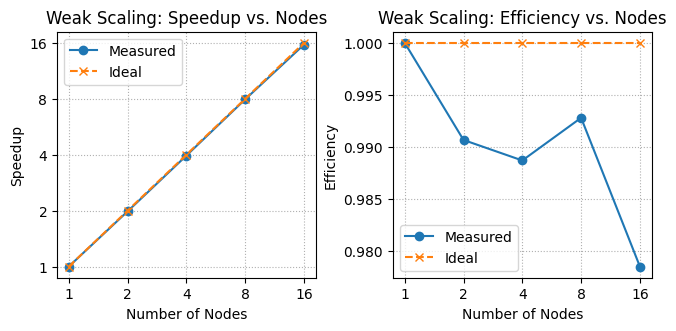

In [34]:
NAME = 'weak.csv'
weak_df = pd.read_csv(DATA_DIR / NAME)
weak_df_sorted = weak_df.sort_values(by='nodes')
baseline_nodes = weak_df_sorted['nodes'].iloc[0]
baseline_time = weak_df_sorted['total_time'].iloc[0]
weak_df_sorted['efficiency'] = baseline_time / weak_df_sorted['total_time']
weak_df_sorted['speedup'] = weak_df_sorted['efficiency'] * weak_df_sorted['nodes']  # optional for completeness

with plt.style.context("default"):
    plt.rcParams['text.usetex'] = False
    fig, axes = make_scaling_figure(weak_df_sorted, baseline_nodes, "Weak")
    plt.show()

# with plt.style.context("slide.mplstyle"):
#     fig, axes = make_scaling_figure(weak_df_sorted, baseline_nodes, "Weak")
#     fig.savefig("../slide/images/weak_speed_eff.pgf",
#                 bbox_inches="tight", pad_inches=0.02)

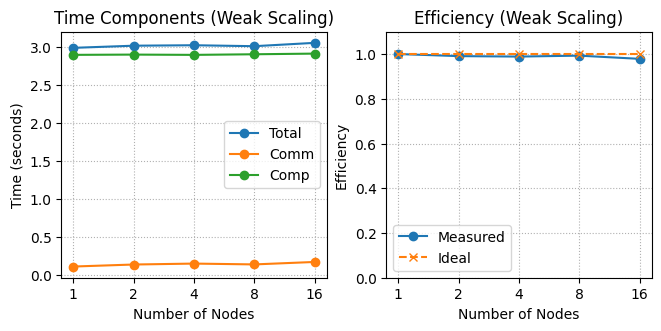

In [36]:


fig, axes = plt.subplots(1, 2, figsize=(6.5, 3.2), constrained_layout=True)

# --- Left subplot: Time components ---
ax = axes[0]
ax.plot(weak_df_sorted['nodes'], weak_df_sorted['total_time'], marker='o', linestyle='-', label='Total')
ax.plot(weak_df_sorted['nodes'], weak_df_sorted['comm_time'],  marker='o', linestyle='-', label='Comm')
ax.plot(weak_df_sorted['nodes'], weak_df_sorted['comp_time'],  marker='o', linestyle='-', label='Comp')
ax.set_title('Time Components (Weak Scaling)')
ax.set_xlabel('Number of Nodes')
ax.set_ylabel('Time (seconds)')
ax.set_xscale('log', base=2)
ax.set_xticks(weak_df_sorted['nodes'])
ax.set_xticklabels(weak_df_sorted['nodes'])
ax.grid(True, which='both', linestyle=':')
ax.legend()

# --- Right subplot: Efficiency ---
ax = axes[1]
ax.plot(weak_df_sorted['nodes'], weak_df_sorted['efficiency'], marker='o', linestyle='-', label='Measured')
ax.plot(weak_df_sorted['nodes'], np.ones_like(weak_df_sorted['nodes']), marker='x', linestyle='--', label='Ideal')
ax.set_title('Efficiency (Weak Scaling)')
ax.set_xlabel('Number of Nodes')
ax.set_ylabel('Efficiency')
ax.set_xscale('log', base=2)
ax.set_xticks(weak_df_sorted['nodes'])
ax.set_xticklabels(weak_df_sorted['nodes'])
ax.set_ylim(0, 1.1)
ax.grid(True, which='both', linestyle=':')
ax.legend()

with plt.style.context("default"):
    plt.rcParams['text.usetex'] = False
    plt.show()

with plt.style.context("slide.mplstyle"):
    fig.savefig("../slide/images/weak_times_eff.pgf",
                bbox_inches="tight", pad_inches=0.02)